In [1]:
from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def load_data(filename, train_evo, test_evo, steps, window_size,
              normalization='none'):
    """
    Load data. Add input pulse profile as the first step.
    The input for the network is 'window_size' times the input profile.

    Parameters
    ----------
    filename : filename as string
    train_evo : number of training evolutions as integer
    test_evo : number of test evolutions as integer
    steps : number of propagation steps as integer
    window_size : RNN window size as integer
    normalization : none (default), max, dBm, manual ...

    Returns
    -------
    i_x : number of grid points (spectral/temporal) as integer
    X_train : training data input, shape (N, window_size, i_x)
    X_test : testing data input, shape (M, window_size, i_x)
    Y_train : training data output, shape (N, i_x)
    Y_test : testing data output, shape (M, i_x)
    """

    # Load data
    mat_contents = sio.loadmat(filename)
    data = mat_contents['data_s_all']
    print("data loaded...")
    print(data.shape)

    if normalization == 'none':
        pass
        
    elif normalization == 'max':  # linear scale (normalized)
        m_max = np.max(np.fabs(data))
        print('max:', m_max)
        data = data/m_max

    elif normalization == 'dBm':  # logarithmic scale
        m_max = np.max(np.fabs(data))
        print('max:', m_max)
        data=data/m_max  # normalize
        data = 10*np.log10(data)  # dB scale
        dBlim = 50  # define dynamic range
        data[data < -dBlim] = -dBlim  # set spectrum <-55 to -55
        data = data/dBlim+1
        

    elif normalization == 'manual':
        m_max = 10369993.175721595 # SC spectral domain
        print('max:', m_max)
        data = data/m_max


    # the number of grid points
    i_x = data.shape[1]

    # Make the time series
    num_evo = train_evo + test_evo
    evo_size = steps - 1
    num_samples = np.round(num_evo*evo_size).astype(int)
    X_data_series = np.zeros((num_samples, window_size, i_x))
    Y_data_series = np.zeros((num_samples, i_x))

    for evo in range(num_evo):
        evo_data = np.transpose(data[evo, :, :])

        # tile the beginning of the evolution with 'window_size' input profiles
        temp1 = evo_data[0, :]
        temp2 = np.tile(temp1, (window_size - 1, 1))
        evo_data = np.vstack((temp2, evo_data))

        for step in range(evo_size):
            input_data = evo_data[step:step + window_size, :]
            output_data = evo_data[step + window_size, :]
            series_idx = evo*evo_size + step
            X_data_series[series_idx, :, :] = input_data
            Y_data_series[series_idx, :] = output_data


    X_train = X_data_series[:num_samples - test_evo*evo_size]
    X_test = X_data_series[num_samples - test_evo*evo_size:]
    Y_train = Y_data_series[:num_samples - test_evo*evo_size]
    Y_test = Y_data_series[num_samples - test_evo*evo_size:]

    return i_x, X_train, X_test, Y_train, Y_test, data

In [3]:
filename = '/content/drive/MyDrive/NatMI_MMFwRNN/Data/data_s_all.mat'

window_size = 10 # RNN window size
num_epoch = 50 # number of epochs
#num_epoch = 10 # number of epochs

train_evo, test_evo, steps = 974, 50, 120
added_params = 0


i_x, X_train, X_test, Y_train, Y_test, data = load_data(filename, train_evo,test_evo, steps,window_size,'max') # max/dBm

data loaded...
(1024, 1024, 120)
max: 1.7176472098024462e+19


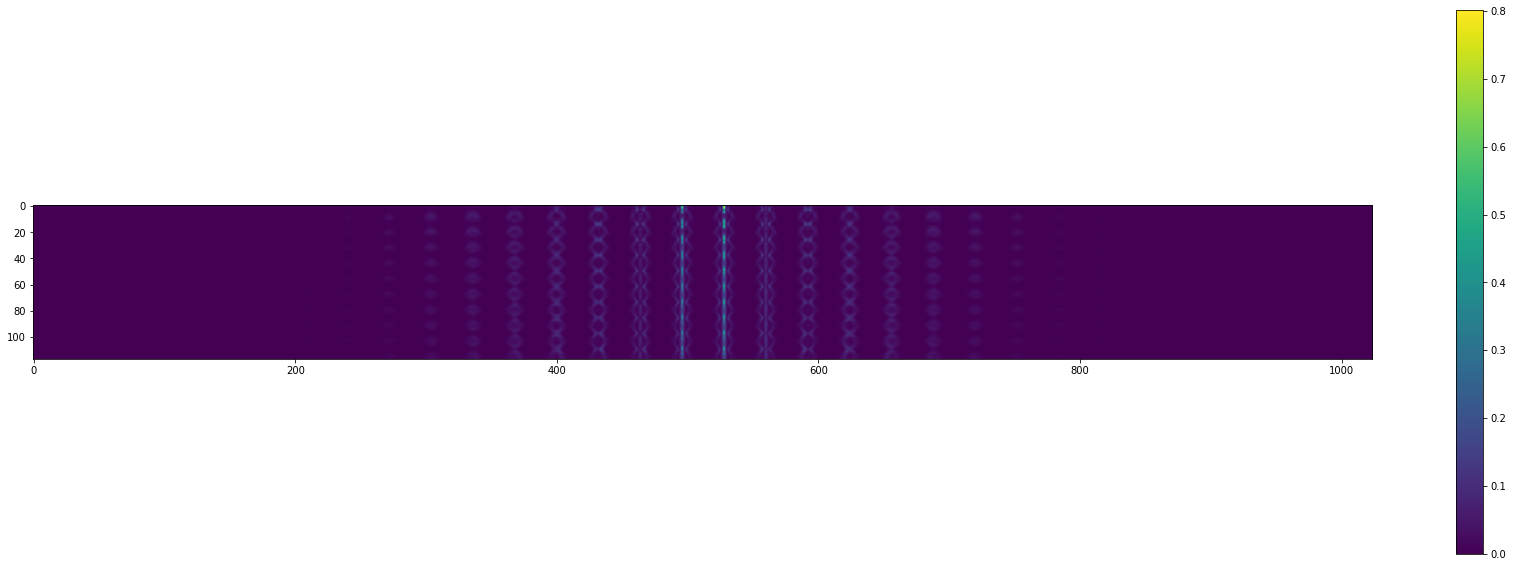

In [4]:
a = 2
plt.figure(figsize=(30, 10))
plt.imshow(Y_test[a*120:(a+1)*120-a-1,:])
plt.colorbar()
plt.show()

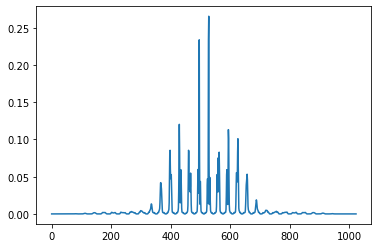

In [5]:
a = 10
plt.plot(Y_test[(119*a)-a,:])
plt.show()

In [6]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(115906, 10, 1024) (5950, 10, 1024) (115906, 1024) (5950, 1024)


In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, LSTM
from keras.utils import np_utils
from keras.callbacks import History
from keras import optimizers


def make_RNN_model(window_size, i_x, added_params=0):
    """
    Create RNN model

    Parameters
    ----------
    window_size : RNN window size as integer
    i_x : number of grid points as integer
    added_params : number of additional parameters as integer (optional)

    Returns
    -------
    model : keras model
    """

    # Define model architecture
    model = Sequential()

    a = 'relu'
    input_shape = (window_size, i_x+added_params)

    model.add(LSTM(750, activation=a, input_shape=input_shape))
    model.add(Dense(750, activation=a))
    model.add(Dense(750, activation=a))
    model.add(Dense(i_x, activation='sigmoid'))

    # Compile model
    optimizer = optimizers.RMSprop(lr=1e-4, rho=0.9)
    loss = 'mean_squared_error'
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['mse', 'mae'])

    return model

In [8]:
model = make_RNN_model(window_size, i_x)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 750)               5325000   
_________________________________________________________________
dense (Dense)                (None, 750)               563250    
_________________________________________________________________
dense_1 (Dense)              (None, 750)               563250    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              769024    
Total params: 7,220,524
Trainable params: 7,220,524
Non-trainable params: 0
_________________________________________________________________


In [10]:
### Fit model on training data
history = model.fit(X_train, Y_train,epochs=num_epoch,validation_split=0.1,verbose=2)

Epoch 1/50
3260/3260 - 53s - loss: 0.0012 - mse: 0.0012 - mae: 0.0059 - val_loss: 6.6146e-05 - val_mse: 6.6146e-05 - val_mae: 0.0026
Epoch 2/50
3260/3260 - 50s - loss: 3.6715e-05 - mse: 3.6715e-05 - mae: 0.0021 - val_loss: 3.3426e-05 - val_mse: 3.3426e-05 - val_mae: 0.0019
Epoch 3/50
3260/3260 - 50s - loss: 2.4857e-05 - mse: 2.4857e-05 - mae: 0.0018 - val_loss: 2.9644e-05 - val_mse: 2.9644e-05 - val_mae: 0.0018
Epoch 4/50
3260/3260 - 50s - loss: 1.7026e-05 - mse: 1.7026e-05 - mae: 0.0016 - val_loss: 2.0779e-05 - val_mse: 2.0779e-05 - val_mae: 0.0016
Epoch 5/50
3260/3260 - 50s - loss: 1.2100e-05 - mse: 1.2100e-05 - mae: 0.0014 - val_loss: 1.2139e-05 - val_mse: 1.2139e-05 - val_mae: 0.0013
Epoch 6/50
3260/3260 - 50s - loss: 9.3139e-06 - mse: 9.3139e-06 - mae: 0.0013 - val_loss: 1.1544e-05 - val_mse: 1.1544e-05 - val_mae: 0.0013
Epoch 7/50
3260/3260 - 50s - loss: 6.9899e-06 - mse: 6.9899e-06 - mae: 0.0011 - val_loss: 7.4441e-06 - val_mse: 7.4441e-06 - val_mae: 0.0011
Epoch 8/50
3260/3260 

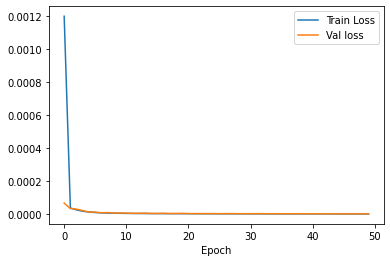

In [11]:
plt.figure()
plt.xlabel('Epoch')
plt.plot(history.epoch, np.array(history.history['loss']),label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Val loss')
plt.legend()
plt.show()

In [12]:
model.save('/content/drive/MyDrive/NatMI_MMFwRNN/Data/evo_wave.h5')

In [13]:
print("TESTING STEP-WISE...")
Y_submit = model.predict_proba(X_test)

TESTING STEP-WISE...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [14]:
Y_submit.shape

(5950, 1024)

In [15]:
sio.savemat('/content/drive/MyDrive/NatMI_MMFwRNN/Data/test_results_wave.mat', {'Y_submit':Y_submit, 'Y_test':Y_test, 'steps':steps,'window_size':window_size})

In [16]:
def pred_evo(model, X_test, test_evo, steps, window_size, i_x):
    """
    Predict evolution from a given input step. The input is 'window_size' times
    the given input.

    Parameters
    ----------
    model : Keras model
    X_test: : test data, size (samples, window_size, i_x)
    test_evo : number of test evolutions as integer
    steps : steps as integer
    window_size : RNN window size as integer
    i_x : number of grid points (spectral/temporal) as integer

    Returns
    -------
    Y_submit : results matrix, size (samples, i_x)
    """

    # Make the time series
    evo_size = steps - 1
    Y_submit = np.zeros((test_evo, evo_size, i_x))
    test_data = X_test[::evo_size,:,:]  # select fiber input profiles

    for step in range(evo_size):
        test_result = model.predict_proba(test_data)
        Y_submit[:,step,:] = test_result
        test_result = np.expand_dims(test_result, axis=1)
        test_data = np.concatenate((test_data,test_result), axis=1)
        test_data = test_data[:, 1:, :]

    # reshape to the original dimensions
    Y_submit = np.reshape(Y_submit,(evo_size*test_evo, i_x))

    return Y_submit

In [17]:
Y_submit = pred_evo(model, X_test, test_evo, steps, window_size, i_x)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [18]:
Y_submit.shape

(5950, 1024)

In [19]:
sio.savemat('/content/drive/MyDrive/NatMI_MMFwRNN/Data/full_test_results_wave.mat', {'Y_submit':Y_submit, 'Y_test':Y_test, 'steps':steps,'window_size':window_size})

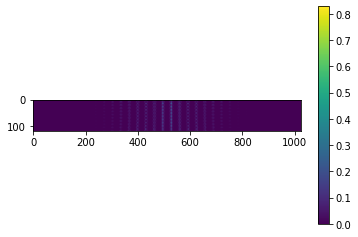

In [20]:
plt.imshow(Y_test[0:119,:])
plt.colorbar()
plt.show()

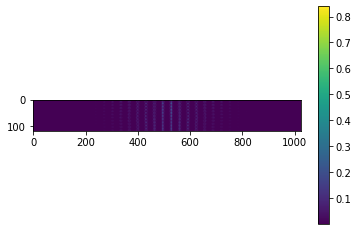

In [21]:
#plt.figure(figsize=(30, 10))
plt.imshow(Y_submit[0:119,:])
plt.colorbar()
plt.show()

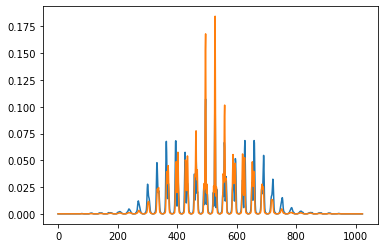

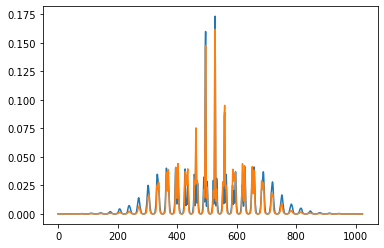

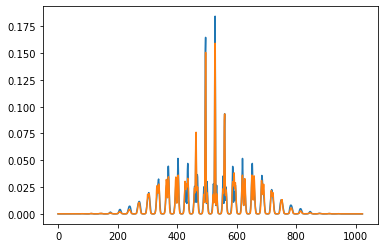

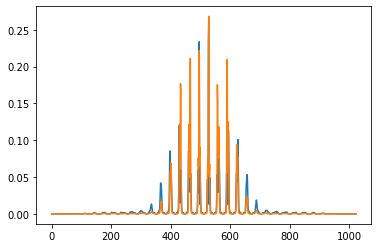

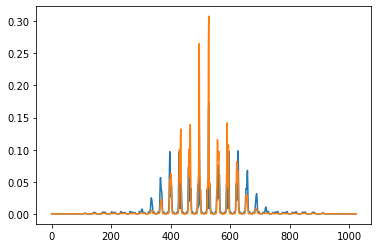

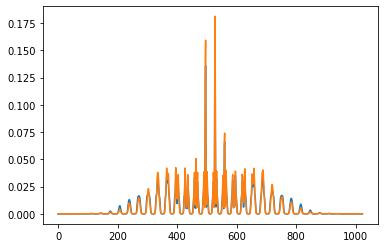

In [22]:
n = [1,2,3,10,11,50]

for i in range(len(n)):
    a = int(n[i])
    plt.plot(Y_test[(119*a)-a,:])
    plt.plot(Y_submit[(119*a)-a,:])
    #plt.xlim([110, 140]) 
    plt.show()